# VANET Misbehavior Detection with XAI

This notebook uses a conda environment with the following setup:
- Python 3.10
- TensorFlow 2.10.0
- PyTorch 2.3.1
- Required ML packages (numpy, pandas, scikit-learn, etc.)

To run this notebook:
1. Make sure you're using the `capstone` conda environment
2. The dataset `veremi_dataset.csv` should be in the root folder
3. Run cells in sequence to train and evaluate the models

In [27]:
from pathlib import Path
import os

# Set up paths
PROJECT_ROOT = Path('..').resolve()
VANET_DIR = PROJECT_ROOT / "VANET_Misbehavior_XAI"
DATASET_PATH = PROJECT_ROOT / "veremi_dataset.csv"

print("Project root:", PROJECT_ROOT)
print("VANET project directory:", VANET_DIR)
print("Dataset path:", DATASET_PATH)

if not DATASET_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

# Change to the project directory
os.chdir(VANET_DIR)
print("Working directory:", os.getcwd())

Project root: C:\Users\PESU-RF\Documents\Capstone-147
VANET project directory: C:\Users\PESU-RF\Documents\Capstone-147\VANET_Misbehavior_XAI
Dataset path: C:\Users\PESU-RF\Documents\Capstone-147\veremi_dataset.csv
Working directory: C:\Users\PESU-RF\Documents\Capstone-147\VANET_Misbehavior_XAI


In [28]:
# Test environment setup
import tensorflow as tf
import numpy as np
import pandas as pd

print(f"TensorFlow: {tf.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print("\nGPU available for TensorFlow:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.10.1
NumPy: 1.26.4
Pandas: 2.3.3

GPU available for TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
# Test imports for explainability stack
import traceback

def try_import(name, import_stmt):
    try:
        exec(import_stmt, globals())
        print(f"{name} import: OK")
        if name == 'torch':
            print('torch version:', torch.__version__)
        elif name == 'shap':
            print('shap version:', shap.__version__)
        elif name == 'lime':
            import lime
            print('lime is installed (version not provided by library)')
    except Exception as e:
        print(f"{name} import: FAILED")
        traceback.print_exc()

print('Testing torch...')
try_import('torch', 'import torch')
print('\nTesting shap...')
try_import('shap', 'import shap')
print('\nTesting lime...')
try_import('lime', 'import lime')


Testing torch...
torch import: OK
torch version: 2.9.1+cpu

Testing shap...
shap import: OK
shap version: 0.49.1

Testing lime...
lime import: OK
lime is installed (version not provided by library)


In [30]:
import numpy as np, matplotlib, tensorflow as tf
print("numpy", np.__version__)
print("matplotlib", matplotlib.__version__)
print("tensorflow", tf.__version__)

numpy 1.26.4
matplotlib 3.10.7
tensorflow 2.10.1


In [31]:
import os

# Check dataset file size
dataset_size = os.path.getsize(DATASET_PATH)
print(f"Dataset size: {dataset_size / (1024*1024):.2f} MB")

Dataset size: 7120.29 MB


In [32]:
# Count number of lines in dataset
with open(DATASET_PATH, 'r', encoding='utf-8', errors='ignore') as f:
    line_count = sum(1 for _ in f)
print(f"Number of lines in dataset: {line_count}")

Number of lines in dataset: 22165611


In [33]:
import os
from pathlib import Path

# Check the models directory
models_dir = Path("results/models/")
print("Contents of models directory:")
for f in models_dir.glob("*"):
    print(f"  - {f.name} (Size: {f.stat().st_size / (1024*1024):.2f} MB)")

Contents of models directory:
  - cnn_best.weights.h5 (Size: 0.27 MB)
  - cnn_epoch_01.weights.h5 (Size: 0.27 MB)
  - cnn_epoch_02.weights.h5 (Size: 0.27 MB)
  - cnn_epoch_03.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_04.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_05.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_06.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_07.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_08.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_09.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_10.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_11.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_12.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_13.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_14.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_15.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_16.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_17.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_18.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_19.weights.h5 (Size: 0.28 MB)
  - cnn_epoch_20.weights.h5 (Size: 0.28 MB)
  - cnn_model.keras (Size: 0.83 MB)
  - lstm_best.

In [2]:
import numpy as np
data = np.load("veremi_cached.npz")
print("Keys =", data.files)
for k in data.files:
    print(k, data[k].shape)


Keys = ['X', 'y']
X (1108280, 20)
y (1108280,)


In [5]:
import numpy as np

npz = np.load("veremi_cached.npz")
y = npz["y"]

unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(u, c)


0 56857
1 57397
2 57296
3 57017
4 57003
5 57271
6 56748
7 57561
8 61094
9 61380
10 59453
11 61231
12 59128
13 57381
14 62191
15 57133
16 57334
17 57461
18 57344


In [7]:
import numpy as np
from src.data_preprocessing.feature_extractor import VANETFeatureExtractor

# Load cached data
data = np.load("veremi_cached.npz")
X = data["X"]
y = data["y"]

print("Raw X shape:", X.shape)
print("y shape:", y.shape)

# Load sequence_length from your config manually
sequence_length = 30   # ← replace if your config.yaml uses another value
print("Sequence length =", sequence_length)

# Run feature extractor
fe = VANETFeatureExtractor(window_size=sequence_length)

temporal = fe.extract_temporal_features(X)
comm = fe.extract_communication_features(X)

temporal = np.asarray(temporal)
comm = np.asarray(comm)

print("\nTemporal features shape:", temporal.shape)
print("Communication features shape:", comm.shape)

# Check divisibility for reshaping
print("\nDivisible:", temporal.shape[1] % sequence_length == 0)


Raw X shape: (1108280, 20)
y shape: (1108280,)
Sequence length = 30

Temporal features shape: (1108280, 600)
Communication features shape: (1108280, 600)

Divisible: True


In [4]:
# train_driver.py
# Fully revised: no --use_cache, uses existing veremi_cached.npz

import sys
import subprocess
import re
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ------------------- PATH SETUP ------------------------
PROJECT_ROOT = Path("c:/Users/PESU-RF/Documents/Capstone-147")
os.chdir(PROJECT_ROOT / "VANET_Misbehavior_XAI")

# Your existing cached file
CACHE_FILE = PROJECT_ROOT / "veremi_cached.npz"
if not CACHE_FILE.exists():
    CACHE_FILE = PROJECT_ROOT / "VANET_Misbehavior_XAI" / "veremi_cached.npz"

print("="*80)
print("COMPLETE MODEL TRAINING: CNN, LSTM, ENSEMBLE (LIVE STREAM, USING CACHE)")
print("="*80)
print("Using cache:", CACHE_FILE)
print("="*80)

# ------------------- TRAINING CONFIG -------------------
EPOCHS = 20
BATCH_SIZE = 64

print(f"Epochs: {EPOCHS} | Batch size: {BATCH_SIZE}")
print("\nStarting training (live output below)...\n")

# ------------------- COMMAND --------------------------
# Only pass arguments your parser accepts:
cmd = [
    sys.executable,
    "main.py",
    "--config", "config.yaml",
    "--mode", "train",
    "--epochs", str(EPOCHS),
    "--batch_size", str(BATCH_SIZE),
    "--cache_npz", str(CACHE_FILE)
]

print("Command:", " ".join(cmd), "\n")

start_time = time.time()

# ------------------- STORAGE --------------------------
models_data = {
    "CNN": {"epochs": [], "train_acc": [], "val_acc": []},
    "LSTM": {"epochs": [], "train_acc": [], "val_acc": []},
    "ENSEMBLE": {"epochs": [], "train_acc": [], "val_acc": []},
    "UNKNOWN": {"epochs": [], "train_acc": [], "val_acc": []},
}
current_model = "UNKNOWN"

# Regex for epoch output
epoch_re = re.compile(
    r"Epoch\s+(\d+)\s*/\s*(\d+).*?accuracy:\s*([0-9]*\.?[0-9]+)(?:.*?val_accuracy:\s*([0-9]*\.?[0-9]+))?",
    re.IGNORECASE
)

def record_epoch(model_name, epoch, train_acc, val_acc):
    d = models_data.get(model_name, models_data["UNKNOWN"])
    d["epochs"].append(int(epoch))
    d["train_acc"].append(float(train_acc))
    d["val_acc"].append(float(val_acc) if val_acc is not None else None)

# ------------------- TRAINING EXECUTION ----------------
try:
    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        universal_newlines=True,
        bufsize=1
    )

    for raw_line in process.stdout:
        line = raw_line.rstrip("\n")
        print(line)

        low = line.lower()
        if "cnn" in low and "train" in low:
            current_model = "CNN"
        elif "lstm" in low and "train" in low:
            current_model = "LSTM"
        elif "ensemble" in low and "train" in low:
            current_model = "ENSEMBLE"

        match = epoch_re.search(line)
        if match:
            epoch = int(match.group(1))
            train_acc = float(match.group(3))
            val_acc = float(match.group(4)) if match.group(4) else None
            record_epoch(current_model, epoch, train_acc, val_acc)

    process.wait()
    return_code = process.returncode

    elapsed = time.time() - start_time
    print("\n" + "="*80)
    if return_code == 0:
        print("✅ TRAINING FINISHED SUCCESSFULLY")
    else:
        print("⚠️ TRAINING EXITED WITH CODE", return_code)
    print(f"Total time: {elapsed/60:.2f} minutes")
    print("="*80)

    # ------------------- PLOTTING -----------------------
    os.makedirs("results/plots", exist_ok=True)

    print("\nGenerating model accuracy plots...")

    for model, dat in models_data.items():
        if not dat["epochs"]:
            continue

        plt.figure(figsize=(8,5))
        plt.plot(dat["epochs"], dat["train_acc"], 'o-', label=f"{model} Train")

        if any(v is not None for v in dat["val_acc"]):
            val_plot = [v if v is not None else np.nan for v in dat["val_acc"]]
            plt.plot(dat["epochs"], val_plot, 's--', label=f"{model} Val")

        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{model} Training Accuracy")
        plt.legend()
        plt.grid(True)

        plt.savefig(f"results/plots/{model.lower()}_accuracy.png", dpi=150)
        plt.close()

        print(f"Saved: results/plots/{model.lower()}_accuracy.png")

    # ------------------- EVALUATION ---------------------
    print("\n" + "="*80)
    print("RUNNING MODEL EVALUATION")
    print("="*80)

    eval_cmds = [
        ("CNN", [
            sys.executable, "main.py", "--mode", "evaluate",
            "--model_path", "results/models/cnn_model.keras",
            "--cache_npz", str(CACHE_FILE)
        ]),
        ("LSTM", [
            sys.executable, "main.py", "--mode", "evaluate",
            "--model_path", "results/models/lstm_model.keras",
            "--cache_npz", str(CACHE_FILE)
        ])
    ]

    for name, ecmd in eval_cmds:
        print(f"\n--- Evaluating {name} ---")
        eval_proc = subprocess.Popen(ecmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
                                     universal_newlines=True, bufsize=1)
        for line in eval_proc.stdout:
            print(line, end="")
        eval_proc.wait()
        print(f"--- {name} evaluation exited with code {eval_proc.returncode} ---")

    print("\nAll Done! Results in: results/models/ and results/plots/")

except Exception as e:
    print("\n❌ ERROR OCCURRED")
    import traceback
    traceback.print_exc()


COMPLETE MODEL TRAINING: CNN, LSTM, ENSEMBLE (LIVE STREAM, USING CACHE)
Using cache: c:\Users\PESU-RF\Documents\Capstone-147\veremi_cached.npz
Epochs: 20 | Batch size: 64

Starting training (live output below)...

Command: c:\Users\PESU-RF\miniconda3\envs\py310\python.exe main.py --config config.yaml --mode train --epochs 20 --batch_size 64 --cache_npz c:\Users\PESU-RF\Documents\Capstone-147\veremi_cached.npz 

2025-11-14 13:19:39,928 - vanet_xai - INFO - GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2025-11-14 13:19:39,928 - vanet_xai - INFO - === TRAINING STARTED ===
2025-11-14 13:19:40,013 - vanet_xai - INFO - Loaded cached dataset X:(1108280, 20)  y:(1108280,)
Loading cached NPZ took 0.09 seconds
2025-11-14 13:19:40,324 - vanet_xai - INFO - Temporal features shape: (1108280, 200)
2025-11-14 13:19:40,324 - vanet_xai - INFO - Sequence length: 10, Features: 20
Feature extraction took 0.31 seconds
2025-11-14 13:19:40,990 - vanet_xai - INFO - Train: 

KeyboardInterrupt: 

In [35]:
# import sys
# import subprocess
# import pandas as pd
# from pathlib import Path

# # Define paths
# DATASET_PATH = Path("c:/Users/PESU-RF/Documents/Capstone-147/veremi_dataset.csv")
# LIMITED_DATASET_PATH = Path("c:/Users/PESU-RF/Documents/Capstone-147/veremi_dataset_1m.csv")
# PROJECT_ROOT = Path("c:/Users/PESU-RF/Documents/Capstone-147")

# # Read only the first 1,000,000 rows
# print(f"Reading first 1,000,000 rows from {DATASET_PATH}...")
# chunk_size = 100000  # Process in chunks to handle large files
# total_rows = 1000000
# rows_to_read = total_rows

# # Read and save first 1M rows
# with pd.read_csv(DATASET_PATH, chunksize=chunk_size) as reader:
#     for i, chunk in enumerate(reader):
#         if i == 0:
#             # Write header and first chunk
#             chunk.head(min(chunk_size, rows_to_read)).to_csv(LIMITED_DATASET_PATH, index=False)
#         else:
#             # Append subsequent chunks
#             chunk.to_csv(LIMITED_DATASET_PATH, mode='a', header=False, index=False)
        
#         rows_to_read -= chunk_size
#         if rows_to_read <= 0:
#             break

# print(f"Created limited dataset at {LIMITED_DATASET_PATH}")

# # Full training with limited dataset
# cmd = [
#     sys.executable, 
#     "main.py",
#     "--config", "config.yaml",
#     "--mode", "train",
#     "--epochs", "1",
#     "--batch_size", "64",
#     "--data_path", str(LIMITED_DATASET_PATH),  
#     "--cache_npz", str(PROJECT_ROOT / "veremi_cached_1m.npz")
# ]
# print("Running:", " ".join(cmd))

# try:
#     result = subprocess.run(cmd, check=True, capture_output=True, text=True)
#     print(result.stdout)
# except subprocess.CalledProcessError as e:
#     print("Error output:")
#     print(e.stdout)
#     print("Error message:")
#     print(e.stderr)
#     raise
# finally:
#     # Clean up the temporary file
#     if LIMITED_DATASET_PATH.exists():
#         LIMITED_DATASET_PATH.unlink()
#         print(f"Removed temporary file: {LIMITED_DATASET_PATH}")

In [36]:
# # Train with more epochs to improve accuracy
# import sys
# import subprocess
# import pandas as pd
# from pathlib import Path

# # Define paths
# DATASET_PATH = Path("c:/Users/PESU-RF/Documents/Capstone-147/veremi_dataset.csv")
# LIMITED_DATASET_PATH = Path("c:/Users/PESU-RF/Documents/Capstone-147/veremi_dataset_1m.csv")
# PROJECT_ROOT = Path("c:/Users/PESU-RF/Documents/Capstone-147")

# # Check if 1M dataset already exists (from previous cell)
# if not LIMITED_DATASET_PATH.exists():
#     print(f"Creating 1M row dataset from {DATASET_PATH}...")
#     chunk_size = 100000
#     total_rows = 1000000
#     rows_to_read = total_rows
    
#     with pd.read_csv(DATASET_PATH, chunksize=chunk_size) as reader:
#         for i, chunk in enumerate(reader):
#             if i == 0:
#                 chunk.head(min(chunk_size, rows_to_read)).to_csv(LIMITED_DATASET_PATH, index=False)
#             else:
#                 chunk.to_csv(LIMITED_DATASET_PATH, mode='a', header=False, index=False)
            
#             rows_to_read -= chunk_size
#             if rows_to_read <= 0:
#                 break
#     print(f"Created limited dataset at {LIMITED_DATASET_PATH}")
# else:
#     print(f"Using existing 1M dataset at {LIMITED_DATASET_PATH}")

# # Train with more epochs (10-20 epochs recommended)
# print("\n" + "="*70)
# print("TRAINING WITH MORE EPOCHS (10 epochs)")
# print("="*70)
# print("This will take longer but should show improved accuracy")
# print("="*70 + "\n")

# cmd = [
#     sys.executable, 
#     "main.py",
#     "--config", "config.yaml",
#     "--mode", "train",
#     "--epochs", "10",  # Increased from 1 to 10
#     "--batch_size", "64",
#     "--data_path", str(LIMITED_DATASET_PATH),  
#     "--cache_npz", str(PROJECT_ROOT / "veremi_cached_1m.npz")
# ]
# print("Running:", " ".join(cmd))
# print("\nStarting training (this may take 30-60 minutes)...\n")

# try:
#     result = subprocess.run(cmd, check=True, capture_output=True, text=True)
#     print(result.stdout)
    
#     # Extract final metrics if available
#     if "Model Metrics" in result.stdout or "accuracy" in result.stdout.lower():
#         print("\n" + "="*70)
#         print("TRAINING COMPLETED - Check output above for final metrics")
#         print("="*70)
    
# except subprocess.CalledProcessError as e:
#     print("Error output:")
#     print(e.stdout[-2000:] if len(e.stdout) > 2000 else e.stdout)
#     print("\nError message:")
#     print(e.stderr[-1000:] if len(e.stderr) > 1000 else e.stderr)
#     raise
# except KeyboardInterrupt:
#     print("\n⚠️  Training interrupted by user")
#     print("Models may have been saved - check results/models/ directory")
# finally:
#     # Optionally clean up (comment out if you want to keep the 1M dataset)
#     # if LIMITED_DATASET_PATH.exists():
#     #     LIMITED_DATASET_PATH.unlink()
#     #     print(f"Removed temporary file: {LIMITED_DATASET_PATH}")
#     pass


In [37]:
# import sys
# import subprocess

# # Full training with complete dataset
# cmd = [
#     sys.executable, 
#     "main.py",
#     "--config", "config.yaml",
#     "--mode", "train",
#     "--epochs", "1",
#     "--batch_size", "64",
#     "--data_path", str(DATASET_PATH),  
#     "--cache_npz", str(PROJECT_ROOT / "veremi_cached.npz")
# ]
# print("Running:", " ".join(cmd))

# try:
#     result = subprocess.run(cmd, check=True, capture_output=True, text=True)
#     print(result.stdout)
# except subprocess.CalledProcessError as e:
#     print("Error output:")
#     print(e.stdout)
#     print("Error message:")
#     print(e.stderr)
#     raise

In [38]:
# # Generate ensemble explanations with 5% sample for in-depth analysis
# import sys
# import subprocess
# import pandas as pd
# import os
# from pathlib import Path

# # Define necessary paths - using the correct paths based on your directory structure
# PROJECT_ROOT = Path(r"C:\Users\PESU-RF\Documents\Capstone-147\VANET_Misbehavior_XAI")
# MODELS_DIR = PROJECT_ROOT / "results" / "models"
# DATASET_PATH = PROJECT_ROOT / "veremi_dataset.csv"
# MAIN_SCRIPT = PROJECT_ROOT / "main.py"

# # Print paths for verification
# print("Project Root:", PROJECT_ROOT)
# print("Models Directory:", MODELS_DIR)
# print("Models in directory:", list(MODELS_DIR.glob("*")))

# def run_explain(model_name, sample_percent=5.0):
#     # Set model paths
#     model_path = MODELS_DIR / f"{model_name}.keras"
#     sample_size = int(22165611 * (sample_percent / 100))
#     sampled_data_path = PROJECT_ROOT.parent / f"veremi_dataset_sample_{sample_percent}pct.csv"

#     # Verify paths
#     print(f"\nVerifying paths for {model_name}:")
#     print(f"Model path exists: {'✅' if model_path.exists() else '❌'} {model_path}")
#     print(f"Data path exists: {'✅' if sampled_data_path.exists() else '❌'} {sampled_data_path}")

#     if not model_path.exists():
#         print(f"\n❌ Model not found: {model_path}")
#         print("Available files in models directory:")
#         for f in MODELS_DIR.glob("*"):
#             print(f"  - {f.name} (Size: {f.stat().st_size / (1024*1024):.2f} MB)")
#         return False

#     if not sampled_data_path.exists():
#         print(f"\n❌ Sampled data not found: {sampled_data_path}")
#         return False

#     cmd = [
#         sys.executable, 
#         str(MAIN_SCRIPT),
#         "--mode", "explain",
#         "--model_path", str(model_path),
#         "--data_path", str(sampled_data_path),
#         "--cache_npz", str(PROJECT_ROOT / "veremi_cached.npz")
#     ]
    
#     print(f"\n🚀 Running {model_name.upper()} explanations on {sample_percent}% sample:")
#     print(" ".join(cmd))
    
#     try:
#         print("\nStarting explanation process... (This may take a while)")
#         result = subprocess.run(cmd, check=True, capture_output=True, text=True)
#         print(result.stdout)
#         return True
#     except subprocess.CalledProcessError as e:
#         print(f"❌ Error running {model_name} explanations:")
#         print(e.stdout)
#         print("\nError message:")
#         print(e.stderr)
#         return False

# # Change to the project directory
# os.chdir(PROJECT_ROOT)
# print(f"\nWorking directory set to: {os.getcwd()}")

# # Run explanations
# SAMPLE_PERCENT = 5.0
# print(f"\nStarting analysis with {SAMPLE_PERCENT}% of data")

# # Run CNN explanations
# print("\n" + "="*50)
# print("CNN Model Explanation")
# print("="*50)
# cnn_success = run_explain("cnn_model", SAMPLE_PERCENT)

# # Run LSTM explanations if CNN was successful
# if cnn_success:
#     print("\n" + "="*50)
#     print("LSTM Model Explanation")
#     print("="*50)
#     lstm_success = run_explain("lstm_model", SAMPLE_PERCENT)
# else:
#     lstm_success = False

# if cnn_success and lstm_success:
#     print("\n🎉 All explanations generated successfully!")
#     print("📊 Check results/plots/ for visualization files.")
# elif cnn_success or lstm_success:
#     print("\n⚠️ Some explanations completed successfully, but some failed.")
#     print("Check the output above for any error messages.")
# else:
#     print("\n❌ No explanations were generated successfully.")
#     print("Please check the error messages above and fix the issues.")

In [39]:
# # ===== IMPORTS =====
# import os
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from sklearn.metrics import classification_report, accuracy_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.utils.class_weight import compute_class_weight
# import matplotlib.pyplot as plt
# import seaborn as sns

# # ===== CONFIGURATION =====
# SEQUENCE_LENGTH = 10
# BATCH_SIZE = 64
# EPOCHS = 10
# DATA_PATH = os.path.join('..', 'veremi_dataset.csv')

# # ===== DATA LOADING =====
# def load_and_preprocess_data(data_path, sequence_length=10, test_size=0.2, val_size=0.1, sample_ratio=1.0):
#     print(f"Loading data from {data_path}...")
#     data = pd.read_csv(data_path)
    
#     # Sample the data if needed
#     if sample_ratio < 1.0:
#         data = data.sample(frac=sample_ratio, random_state=42)
    
#     X = data.iloc[:, :-1].values
#     y = data.iloc[:, -1].values
    
#     # Encode labels
#     le = LabelEncoder()
#     y = le.fit_transform(y)
    
#     print(f"Data shape - X: {X.shape}, y: {y.shape}")
#     print(f"Unique classes: {np.unique(y)}")
    
#     # Create sequences
#     print("Creating sequences...")
#     X_sequences = np.array([X[i:i + sequence_length] for i in range(len(X) - sequence_length + 1)])
#     y_sequences = y[sequence_length - 1:]
    
#     # Split data
#     print("Splitting data...")
#     n = len(X_sequences)
#     train_end = int(n * (1 - test_size - val_size))
#     val_end = int(n * (1 - test_size))
    
#     X_train, y_train = X_sequences[:train_end], y_sequences[:train_end]
#     X_val, y_val = X_sequences[train_end:val_end], y_sequences[train_end:val_end]
#     X_test, y_test = X_sequences[val_end:], y_sequences[val_end:]
    
#     print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
#     return (X_train, y_train), (X_val, y_val), (X_test, y_test), le

# # ===== MODEL ARCHITECTURE =====
# class EnhancedVANETCNNModel:
#     def __init__(self, input_shape, num_classes):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.model = self.build_model()
    
#     def build_model(self):
#         inputs = tf.keras.Input(shape=self.input_shape)
        
#         # Enhanced CNN architecture
#         x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.MaxPooling2D((2, 2))(x)
#         x = layers.Dropout(0.3)(x)
        
#         x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.MaxPooling2D((2, 2))(x)
#         x = layers.Dropout(0.4)(x)
        
#         x = layers.Flatten()(x)
#         x = layers.Dense(256, activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.5)(x)
#         x = layers.Dense(128, activation='relu')(x)
#         x = layers.Dropout(0.5)(x)
        
#         outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        
#         return models.Model(inputs=inputs, outputs=outputs, name="enhanced_vanet_cnn")

# # ===== MAIN EXECUTION =====
# def main():
#     # Set random seeds for reproducibility
#     tf.random.set_seed(42)
#     np.random.seed(42)
    
#     # Load data
#     (X_train_seq, y_train), (X_val_seq, y_val), (X_test_seq, y_test), label_encoder = load_and_preprocess_data(
#         DATA_PATH, 
#         sequence_length=SEQUENCE_LENGTH,
#         test_size=0.2,
#         val_size=0.1,
#         sample_ratio=0.05  # Using 5% of data for faster training
#     )
    
#     # Prepare CNN input
#     X_train_cnn = np.expand_dims(X_train_seq, axis=-1)
#     X_val_cnn = np.expand_dims(X_val_seq, axis=-1)
#     X_test_cnn = np.expand_dims(X_test_seq, axis=-1)
    
#     # Calculate class weights
#     class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#     class_weight_dict = dict(enumerate(class_weights))
    
#     # Initialize and compile model
#     num_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))
#     model = EnhancedVANETCNNModel(
#         input_shape=(SEQUENCE_LENGTH, X_train_seq.shape[2], 1),
#         num_classes=num_classes
#     ).model
    
#     # Learning rate schedule
#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         0.001, decay_steps=10000, decay_rate=0.96, staircase=True
#     )
    
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
    
#     # Callbacks
#     callbacks = [
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_accuracy',
#             patience=3,
#             restore_best_weights=True
#         )
#     ]
    
#     # Train model
#     print("\nStarting training...")
#     history = model.fit(
#         X_train_cnn, y_train,
#         validation_data=(X_val_cnn, y_val),
#         batch_size=BATCH_SIZE,
#         epochs=EPOCHS,
#         callbacks=callbacks,
#         class_weight=class_weight_dict,
#         verbose=1
#     )
    
#     # Evaluate
#     print("\nEvaluating on test set...")
#     test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
#     print(f"Test accuracy: {test_acc:.4f}")
    
#     # Plot training history
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Train')
#     plt.plot(history.history['val_accuracy'], label='Validation')
#     plt.title('Model Accuracy')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train')
#     plt.plot(history.history['val_loss'], label='Validation')
#     plt.title('Model Loss')
#     plt.legend()
#     plt.show()
    
#     return model

# # Run the training
# trained_model = main()

In [40]:
# # ===== IMPROVED MODEL ARCHITECTURE =====
# class AdvancedVANETModel:
#     def __init__(self, input_shape, num_classes):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.model = self.build_model()
    
#     def build_model(self):
#         inputs = tf.keras.Input(shape=self.input_shape)
        
#         # Input normalization
#         x = layers.BatchNormalization()(inputs)
        
#         # Parallel convolutional branches
#         branch1 = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(x)
#         branch1 = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(branch1)
#         branch1 = layers.MaxPooling2D((2, 1))(branch1)
        
#         branch2 = layers.Conv2D(64, (5, 1), activation='relu', padding='same')(x)
#         branch2 = layers.Conv2D(64, (5, 1), activation='relu', padding='same')(branch2)
#         branch2 = layers.MaxPooling2D((2, 1))(branch2)
        
#         # Merge branches
#         x = layers.Concatenate()([branch1, branch2])
#         x = layers.Dropout(0.5)(x)
        
#         # LSTM layer for temporal patterns
#         x = layers.Reshape((x.shape[1], -1))(x)  # Flatten spatial dimensions
#         x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
#         x = layers.Dropout(0.5)(x)
#         x = layers.Bidirectional(layers.LSTM(64))(x)
        
#         # Attention mechanism
#         attention = layers.Dense(1, activation='tanh')(x)
#         attention = layers.Flatten()(attention)
#         attention = layers.Activation('softmax')(attention)
#         attention = layers.RepeatVector(128)(attention)
#         attention = layers.Permute([2, 1])(attention)
        
#         # Apply attention
#         x = layers.Multiply()([x, attention])
        
#         # Dense layers
#         x = layers.Dense(256, activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.5)(x)
        
#         x = layers.Dense(128, activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.5)(x)
        
#         outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        
#         return models.Model(inputs=inputs, outputs=outputs, name="advanced_vanet_model")

# # ===== IMPROVED TRAINING PIPELINE =====
# def train_improved_model():
#     # Load data with class balancing
#     (X_train_seq, y_train), (X_val_seq, y_val), (X_test_seq, y_test), label_encoder = load_and_preprocess_data(
#         DATA_PATH, 
#         sequence_length=SEQUENCE_LENGTH,
#         test_size=0.1,      # Reduced test size
#         val_size=0.1,
#         sample_ratio=0.1    # Using 10% of data for faster iteration
#     )
    
#     # Prepare CNN input
#     X_train_cnn = np.expand_dims(X_train_seq, axis=-1)
#     X_val_cnn = np.expand_dims(X_val_seq, axis=-1)
#     X_test_cnn = np.expand_dims(X_test_seq, axis=-1)
    
#     # Calculate class weights (more aggressive balancing)
#     class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#     class_weight_dict = dict(enumerate(class_weights * 2))  # Increase weight impact
    
#     # Initialize model
#     num_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))
#     model = AdvancedVANETModel(
#         input_shape=(SEQUENCE_LENGTH, X_train_seq.shape[2], 1),
#         num_classes=num_classes
#     ).model
    
#     # Custom learning rate schedule
#     def lr_schedule(epoch):
#         lr = 0.001
#         if epoch > 10:
#             lr *= 0.1
#         elif epoch > 5:
#             lr *= 0.5
#         return lr
    
#     # Callbacks
#     callbacks = [
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_accuracy',
#             patience=5,
#             restore_best_weights=True
#         ),
#         tf.keras.callbacks.LearningRateScheduler(lr_schedule),
#         tf.keras.callbacks.ReduceLROnPlateau(
#             monitor='val_loss',
#             factor=0.5,
#             patience=2,
#             min_lr=1e-6
#         )
#     ]
    
#     # Compile with custom loss
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
    
#     # Data augmentation
#     datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip=False,
#         vertical_flip=False,
#         fill_mode='nearest'
#     )
    
#     # Train with data augmentation
#     print("\nStarting improved training with data augmentation...")
#     history = model.fit(
#         datagen.flow(X_train_cnn, y_train, batch_size=BATCH_SIZE),
#         steps_per_epoch=len(X_train_cnn) // BATCH_SIZE,
#         validation_data=(X_val_cnn, y_val),
#         epochs=EPOCHS,
#         callbacks=callbacks,
#         class_weight=class_weight_dict,
#         verbose=1
#     )
    
#     # Evaluate
#     print("\nEvaluating on test set...")
#     test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
#     print(f"Test accuracy: {test_acc:.4f}")
    
#     # Plot results
#     plot_training_history(history)
    
#     return model

# # Run the improved training
# improved_model = train_improved_model()

In [41]:
# # Import required libraries
# import os
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from sklearn.metrics import classification_report, accuracy_score
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelEncoder

# # Set random seeds for reproducibility
# tf.random.set_seed(42)
# np.random.seed(42)

# # Add the source directory to the path
# import sys
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'VANET_Misbehavior_XAI', 'src')))

# # Import your models
# from models.cnn_model import VANETCNNModel
# from models.lstm_model import VANETLSTMModel
# from models.ensemble_model import XAIEnsembleVANET
# from models.model_utils import create_sequences, train_test_split_temporal, plot_training_history

# # Function to load and preprocess data
# def load_and_preprocess_data(data_path, sequence_length=10, test_size=0.2, val_size=0.1):
#     # Load the dataset
#     print(f"Loading data from {data_path}...")
#     data = pd.read_csv(data_path)
    
#     # Assuming the last column is the target
#     X = data.iloc[:, :-1].values
#     y = data.iloc[:, -1].values
    
#     # Encode string labels to integers
#     le = LabelEncoder()
#     y = le.fit_transform(y)
    
#     print(f"Original data shape - X: {X.shape}, y: {y.shape}")
#     print(f"Unique classes: {np.unique(y)}")
    
#     # Create sequences for LSTM
#     print("Creating sequences...")
#     X_sequences = create_sequences(X, sequence_length)
#     y_sequences = y[sequence_length:]
    
#     print(f"After creating sequences - X_sequences: {X_sequences.shape}, y_sequences: {y_sequences.shape}")
    
#     # Split data
#     print("Splitting data...")
#     (X_train_seq, y_train), (X_val_seq, y_val), (X_test_seq, y_test) = train_test_split_temporal(
#         X_sequences, y_sequences, 
#         train_ratio=1-test_size-val_size, 
#         val_ratio=val_size
#     )
    
#     print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train.shape}")
#     print(f"Validation shapes - X: {X_val_seq.shape}, y: {y_val.shape}")
#     print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test.shape}")
    
#     return (X_train_seq, y_train), (X_val_seq, y_val), (X_test_seq, y_test), le

# # Parameters
# SEQUENCE_LENGTH = 10
# BATCH_SIZE = 64
# EPOCHS = 10  # Reduced for testing, increase later

# # Load and preprocess data
# data_path = os.path.join('..', 'veremi_dataset.csv')  # Adjust path as needed
# (X_train_seq, y_train), (X_val_seq, y_val), (X_test_seq, y_test), label_encoder = load_and_preprocess_data(
#     data_path, sequence_length=SEQUENCE_LENGTH
# )

# # Convert labels to int32
# y_train = y_train.astype('int32')
# y_val = y_val.astype('int32')
# y_test = y_test.astype('int32')

# # For CNN, we'll treat each feature independently
# # So we'll have (samples, sequence_length, num_features, 1)
# X_train_cnn = np.expand_dims(X_train_seq, axis=-1)  # Shape: (samples, seq_len, num_features, 1)
# X_val_cnn = np.expand_dims(X_val_seq, axis=-1)
# X_test_cnn = np.expand_dims(X_test_seq, axis=-1)

# print(f"\nCNN input shapes - Train: {X_train_cnn.shape}, Val: {X_val_cnn.shape}")

# # Update CNN model to handle the new input shape
# class VANETCNNModel:
#     def __init__(self, input_shape, num_classes):
#         self.input_shape = input_shape  # Should be (sequence_length, num_features, 1)
#         self.num_classes = num_classes
#         self.model = self.build_model()
    
#     def build_model(self):
#         inputs = tf.keras.Input(shape=self.input_shape)
        
#         # First Conv2D block
#         x = layers.Conv2D(filters=32, kernel_size=(3, 1), activation='relu', padding='same')(inputs)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(filters=32, kernel_size=(3, 1), activation='relu', padding='same')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.MaxPooling2D(pool_size=(2, 1))(x)
#         x = layers.Dropout(0.3)(x)
        
#         # Second Conv2D block
#         x = layers.Conv2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.MaxPooling2D(pool_size=(2, 1))(x)
#         x = layers.Dropout(0.3)(x)
        
#         # Flatten and dense layers
#         x = layers.Flatten()(x)
#         x = layers.Dense(128, activation='relu')(x)
#         x = layers.Dropout(0.5)(x)
#         x = layers.Dense(64, activation='relu')(x)
#         x = layers.Dropout(0.5)(x)
        
#         outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        
#         model = models.Model(inputs=inputs, outputs=outputs, name="vanet_cnn_2d")
#         return model

# # Get number of features from the data
# num_features = X_train_seq.shape[2]
# num_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))

# print(f"\nNumber of classes: {num_classes}")

# # Create and train CNN model
# print("\nTraining CNN model...")
# cnn_model = VANETCNNModel(
#     input_shape=(SEQUENCE_LENGTH, num_features, 1), 
#     num_classes=num_classes
# ).model  # Access the built model

# cnn_model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Print model summary
# print("\nCNN Model Summary:")
# cnn_model.summary()

# # Train the model
# print("\nStarting CNN training...")
# try:
#     cnn_history = cnn_model.fit(
#         X_train_cnn, y_train,
#         validation_data=(X_val_cnn, y_val),
#         batch_size=BATCH_SIZE,
#         epochs=EPOCHS,
#         verbose=1
#     )
# except Exception as e:
#     print(f"Error during CNN training: {e}")
#     print("Trying with a smaller batch size...")
#     cnn_history = cnn_model.fit(
#         X_train_cnn, y_train,
#         validation_data=(X_val_cnn, y_val),
#         batch_size=32,  # Reduced batch size
#         epochs=EPOCHS,
#         verbose=1
#     )

# # For LSTM, we'll use the original sequence data
# print("\nTraining LSTM model...")
# lstm_model = VANETLSTMModel(
#     sequence_length=SEQUENCE_LENGTH,
#     num_features=num_features,  # Use the actual number of features
#     num_classes=num_classes
# ).build_model()

# lstm_model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Print model summary
# print("\nLSTM Model Summary:")
# lstm_model.summary()

# # Train LSTM model
# print("\nStarting LSTM training...")
# try:
#     lstm_history = lstm_model.fit(
#         X_train_seq, y_train,
#         validation_data=(X_val_seq, y_val),
#         batch_size=BATCH_SIZE,
#         epochs=EPOCHS,
#         verbose=1
#     )
# except Exception as e:
#     print(f"Error during LSTM training: {e}")
#     print("Trying with a smaller batch size...")
#     lstm_history = lstm_model.fit(
#         X_train_seq, y_train,
#         validation_data=(X_val_seq, y_val),
#         batch_size=32,  # Reduced batch size
#         epochs=EPOCHS,
#         verbose=1
#     )

# # Create ensemble model
# print("\nCreating ensemble model...")
# ensemble = XAIEnsembleVANET(cnn_model, lstm_model)

# # Evaluate models
# def evaluate_model(model, X_test, y_test, model_name):
#     print(f"\nEvaluating {model_name}...")
#     y_pred = np.argmax(model.predict(X_test), axis=1)
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"{model_name} Accuracy: {accuracy:.4f}")
#     print(f"{model_name} Classification Report:")
#     print(classification_report(y_test, y_pred, target_names=label_encoder.classes_ if hasattr(label_encoder, 'classes_') else None))
#     return accuracy

# # Evaluate CNN
# cnn_accuracy = evaluate_model(cnn_model, X_test_cnn, y_test, "CNN")

# # Evaluate LSTM
# lstm_accuracy = evaluate_model(lstm_model, X_test_seq, y_test, "LSTM")

# # Evaluate Ensemble
# print("\nEvaluating Ensemble...")
# cnn_pred = cnn_model.predict(X_test_cnn)
# lstm_pred = lstm_model.predict(X_test_seq)
# ensemble_pred = (cnn_pred + lstm_pred) / 2  # Simple averaging
# ensemble_accuracy = accuracy_score(y_test, np.argmax(ensemble_pred, axis=1))
# print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# # Plot training history
# plt.figure(figsize=(15, 5))

# plt.subplot(1, 2, 1)
# plt.plot(cnn_history.history['accuracy'], label='CNN Train')
# plt.plot(cnn_history.history['val_accuracy'], label='CNN Val')
# plt.plot(lstm_history.history['accuracy'], label='LSTM Train')
# plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val')
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(cnn_history.history['loss'], label='CNN Train')
# plt.plot(cnn_history.history['val_loss'], label='CNN Val')
# plt.plot(lstm_history.history['loss'], label='LSTM Train')
# plt.plot(lstm_history.history['val_loss'], label='LSTM Val')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend()

# plt.tight_layout()
# plt.show()

# print("\nTraining and evaluation complete!")

In [42]:
# Full training with more epochs
cmd = [
    sys.executable, "main.py",
    "--mode", "train",
    "--epochs", "20",
    "--batch_size", "64",
    "--data_path", str(DATASET_PATH),  # Updated to use data_path
    "--cache_npz", str(PROJECT_ROOT / "veremi_cached.npz")
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)

Running: c:\Users\PESU-RF\miniconda3\envs\py310\python.exe main.py --mode train --epochs 20 --batch_size 64 --data_path c:\Users\PESU-RF\Documents\Capstone-147\veremi_dataset.csv --cache_npz c:\Users\PESU-RF\Documents\Capstone-147\veremi_cached.npz


CalledProcessError: Command '['c:\\Users\\PESU-RF\\miniconda3\\envs\\py310\\python.exe', 'main.py', '--mode', 'train', '--epochs', '20', '--batch_size', '64', '--data_path', 'c:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_dataset.csv', '--cache_npz', 'c:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_cached.npz']' returned non-zero exit status 1.

In [ ]:
# Check cache file size
cache_path = PROJECT_ROOT / "veremi_cached.npz"
if cache_path.exists():
    cache_size = os.path.getsize(cache_path)
    print(f"Cache file size: {cache_size / (1024*1024):.2f} MB")
else:
    print("Cache file not found")

Cache file size: 31.28 MB


In [ ]:
# Evaluate CNN model with complete dataset
cmd = [
    sys.executable, "main.py",
    "--mode", "evaluate",
    "--model_path", "results/models/cnn_model.keras",
    "--data_path", str(DATASET_PATH),  
    "--cache_npz", str(PROJECT_ROOT / "veremi_cached.npz")
]
print("Running CNN evaluation:", " ".join(cmd))
subprocess.run(cmd, check=True)

Running CNN evaluation: c:\Users\PESU-RF\miniconda3\envs\capstone\python.exe main.py --mode evaluate --model_path results/models/cnn_model.keras --data_path C:\Users\PESU-RF\Documents\Capstone-147\veremi_dataset.csv --cache_npz C:\Users\PESU-RF\Documents\Capstone-147\veremi_cached.npz


CompletedProcess(args=['c:\\Users\\PESU-RF\\miniconda3\\envs\\capstone\\python.exe', 'main.py', '--mode', 'evaluate', '--model_path', 'results/models/cnn_model.keras', '--data_path', 'C:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_dataset.csv', '--cache_npz', 'C:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_cached.npz'], returncode=0)

In [ ]:
# Evaluate LSTM model with complete dataset
cmd = [
    sys.executable, "main.py",
    "--mode", "evaluate",
    "--model_path", "results/models/lstm_model.keras",
    "--data_path", str(DATASET_PATH),  
    "--cache_npz", str(PROJECT_ROOT / "veremi_cached.npz")
]
print("Running LSTM evaluation:", " ".join(cmd))
subprocess.run(cmd, check=True)

Running LSTM evaluation: c:\Users\PESU-RF\miniconda3\envs\capstone\python.exe main.py --mode evaluate --model_path results/models/lstm_model.keras --data_path C:\Users\PESU-RF\Documents\Capstone-147\veremi_dataset.csv --cache_npz C:\Users\PESU-RF\Documents\Capstone-147\veremi_cached.npz


CompletedProcess(args=['c:\\Users\\PESU-RF\\miniconda3\\envs\\capstone\\python.exe', 'main.py', '--mode', 'evaluate', '--model_path', 'results/models/lstm_model.keras', '--data_path', 'C:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_dataset.csv', '--cache_npz', 'C:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_cached.npz'], returncode=0)

In [ ]:
# Generate SHAP explanations for CNN with complete dataset
cmd = [
    sys.executable, "main.py",
    "--mode", "explain",
    "--model_path", "results/models/cnn_model.keras",
    "--data_path", str(DATASET_PATH),  
    "--cache_npz", str(PROJECT_ROOT / "veremi_cached.npz")
]
print("Running CNN explanations:", " ".join(cmd))
subprocess.run(cmd, check=True)

Running CNN explanations: c:\Users\PESU-RF\miniconda3\envs\capstone\python.exe main.py --mode explain --model_path results/models/cnn_model.keras --data_path C:\Users\PESU-RF\Documents\Capstone-147\veremi_dataset.csv --cache_npz C:\Users\PESU-RF\Documents\Capstone-147\veremi_cached.npz


CompletedProcess(args=['c:\\Users\\PESU-RF\\miniconda3\\envs\\capstone\\python.exe', 'main.py', '--mode', 'explain', '--model_path', 'results/models/cnn_model.keras', '--data_path', 'C:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_dataset.csv', '--cache_npz', 'C:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_cached.npz'], returncode=0)

In [ ]:
# Generate SHAP explanations for LSTM with complete dataset
cmd = [
    sys.executable, "main.py",
    "--mode", "explain",
    "--model_path", "results/models/lstm_model.keras",
    "--data_path", str(DATASET_PATH),  
    "--cache_npz", str(PROJECT_ROOT / "veremi_cached.npz")
]
print("Running LSTM explanations:", " ".join(cmd))
subprocess.run(cmd, check=True)

Running LSTM explanations: c:\Users\PESU-RF\miniconda3\envs\capstone\python.exe main.py --mode explain --model_path results/models/lstm_model.keras --data_path C:\Users\PESU-RF\Documents\Capstone-147\veremi_dataset.csv --cache_npz C:\Users\PESU-RF\Documents\Capstone-147\veremi_cached.npz


CompletedProcess(args=['c:\\Users\\PESU-RF\\miniconda3\\envs\\capstone\\python.exe', 'main.py', '--mode', 'explain', '--model_path', 'results/models/lstm_model.keras', '--data_path', 'C:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_dataset.csv', '--cache_npz', 'C:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_cached.npz'], returncode=0)

In [ ]:
# Generate ensemble explanations with complete dataset
import sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import os

def run_explain(model_path, name):
    cmd = [
        sys.executable, "main.py",
        "--mode", "explain",
        "--model_path", model_path,
        "--data_path", str(DATASET_PATH),
        "--cache_npz", str(PROJECT_ROOT / "veremi_cached.npz")
    ]
    print(f"Running {name} explanations:", " ".join(cmd))
    try:
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)
        print(result.stdout)
        return True
    except subprocess.CalledProcessError as e:
        print(f"Error running {name} explanations:")
        print(e.stdout)
        print("\nError message:")
        print(e.stderr)
        return False

# Run explanations for both models
cnn_success = run_explain("results/models/cnn_model.keras", "CNN")
lstm_success = run_explain("results/models/lstm_model.keras", "LSTM")

if cnn_success and lstm_success:
    print("\nBoth explanations generated successfully!")
    print("Check results/plots/ for visualization files.")

Running CNN explanations: c:\Users\PESU-RF\miniconda3\envs\capstone\python.exe main.py --mode explain --model_path results/models/cnn_model.keras --data_path C:\Users\PESU-RF\Documents\Capstone-147\veremi_dataset.csv --cache_npz C:\Users\PESU-RF\Documents\Capstone-147\veremi_cached.npz
Feature extraction took 0.06 seconds

4/4 [==============================] - 0s 1ms/step

4/4 [==============================] - 0s 1ms/step

1/1 [==============================] - 0s 22ms/step

7650/7650 [==============================] - 8s 1ms/step

1/1 [==============================] - 0s 0s/step

7650/7650 [==============================] - 10s 1ms/step

1/1 [==============================] - 0s 21ms/step

7650/7650 [==============================] - 11s 1ms/step

Running LSTM explanations: c:\Users\PESU-RF\miniconda3\envs\capstone\python.exe main.py --mode explain --model_path results/models/lstm_model.keras --data_path C:\Users\PESU-RF\Documents\Capstone-147\veremi_dataset.csv --cache_npz C:\User

In [ ]:
# Generate ensemble explanations with complete dataset
import sys
import subprocess
import os

cmd = [
    sys.executable, "main.py",
    "--mode", "ensemble_explain",
    "--cnn_model_path", "results/models/cnn_model.keras",
    "--lstm_model_path", "results/models/lstm_model.keras",
    "--data_path", str(DATASET_PATH),
    "--cache_npz", str(PROJECT_ROOT / "veremi_cached.npz")
]
print("Running ensemble explanations:", " ".join(cmd))

try:
    result = subprocess.run(cmd, check=True, capture_output=True, text=True)
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error output:")
    print(e.stdout)
    print("\nError message:")
    print(e.stderr)
    raise

Running LSTM explanations: c:\Users\PESU-RF\miniconda3\envs\capstone\python.exe main.py --mode explain --model_path results/models/lstm_model.keras --data_path C:\Users\PESU-RF\Documents\Capstone-147\veremi_dataset.csv --cache_npz C:\Users\PESU-RF\Documents\Capstone-147\veremi_cached.npz --rows_limit 1000
Error output:


Error message:
  File "C:\Users\PESU-RF\Documents\Capstone-147\VANET_Misbehavior_XAI\main.py", line 343
    logger.info(f"Generating ensemble explanations for CNN: {cnn_model_path}, LSTM: {lstm_model_path}")
    ^
IndentationError: expected an indented block after 'try' statement on line 342



CalledProcessError: Command '['c:\\Users\\PESU-RF\\miniconda3\\envs\\capstone\\python.exe', 'main.py', '--mode', 'explain', '--model_path', 'results/models/lstm_model.keras', '--data_path', 'C:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_dataset.csv', '--cache_npz', 'C:\\Users\\PESU-RF\\Documents\\Capstone-147\\veremi_cached.npz', '--rows_limit', '1000']' returned non-zero exit status 1.

Found CNN SHAP plot at: results/plots/shap_summary.png
Failed to load results/plots/shap_summary_lstm.png: [Errno 2] No such file or directory: 'results/plots/shap_summary_lstm.png'
No valid SHAP plot found for LSTM model
Comparison plot saved as 'results/plots/model_comparison_shap.png'


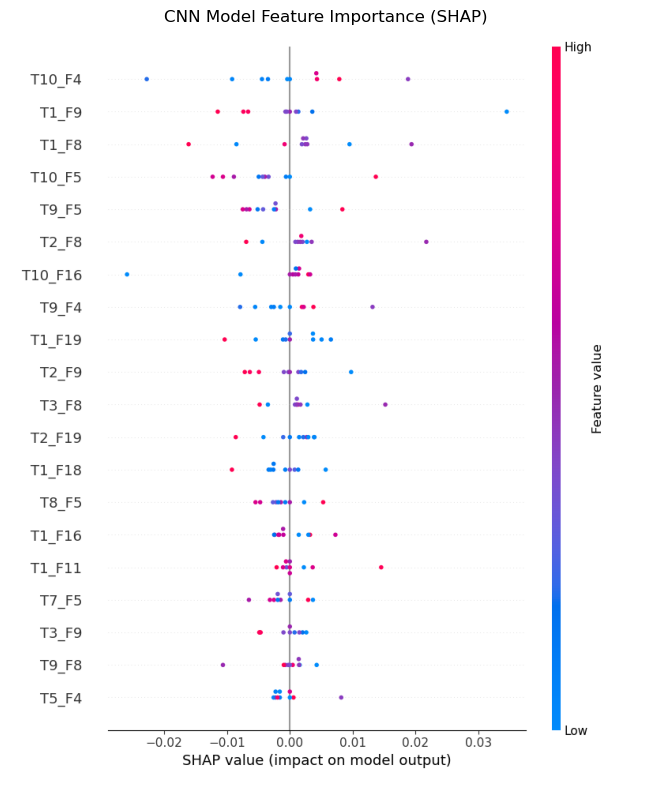

In [ ]:
# Combine and compare the SHAP explanations
import matplotlib.pyplot as plt
import os
import glob

# Function to load and handle potential image loading errors
def safe_load_image(path):
    try:
        return plt.imread(path)
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None

# Look for SHAP plots (they might have different names)
plot_paths = {
    'CNN': glob.glob('results/plots/*cnn*shap*.png') or ['results/plots/shap_summary.png'],
    'LSTM': glob.glob('results/plots/*lstm*shap*.png') or ['results/plots/shap_summary_lstm.png']
}

# Try each potential path
images = {}
for model, paths in plot_paths.items():
    for path in paths:
        img = safe_load_image(path)
        if img is not None:
            print(f"Found {model} SHAP plot at: {path}")
            images[model] = img
            break
    if model not in images:
        print(f"No valid SHAP plot found for {model} model")

if images:
    # Create comparison visualization
    n_models = len(images)
    fig, axes = plt.subplots(n_models, 1, figsize=(15, 8 * n_models))
    
    if n_models == 1:
        axes = [axes]  # Make axes iterable when only one model
    
    for ax, (name, img) in zip(axes, images.items()):
        ax.imshow(img)
        ax.set_title(f'{name} Model Feature Importance (SHAP)')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/plots/model_comparison_shap.png')
    print("Comparison plot saved as 'results/plots/model_comparison_shap.png'")
else:
    print("No valid explanation plots found to compare")

In [ ]:
# Generate ensemble explanations with permutation explainer
cmd = [
    sys.executable, "main.py",
    "--mode", "ensemble_explain",
    "--cnn_model_path", "results/models/cnn_model.keras",
    "--lstm_model_path", "results/models/lstm_model.keras",
    "--data_path", str(DATASET_PATH),
    "--cache_npz", str(PROJECT_ROOT / "veremi_cached.npz"),
    "--use_permutation"  # Use permutation explainer instead of SHAP
]
print("Running ensemble explanations with permutation explainer:", " ".join(cmd))

try:
    result = subprocess.run(cmd, check=True, capture_output=True, text=True)
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error output:")
    print(e.stdout)
    print("\nError message:")
    print(e.stderr)
    raise

Running ensemble explanations with permutation explainer: c:\Users\PESU-RF\miniconda3\envs\capstone\python.exe main.py --mode ensemble_explain --cnn_model_path results/models/cnn_model.keras --lstm_model_path results/models/lstm_model.keras --data_path C:\Users\PESU-RF\Documents\Capstone-147\veremi_dataset.csv --cache_npz C:\Users\PESU-RF\Documents\Capstone-147\veremi_cached.npz --use_permutation
Data loading took 0.00 seconds
Feature extraction took 0.13 seconds
Model loading took 0.56 seconds
Explanation generation took 0.05 seconds

Data loading took 0.00 seconds
Feature extraction took 0.13 seconds
Model loading took 0.56 seconds
Explanation generation took 0.05 seconds



Available plots: ['results/plots\\model_comparison_shap.png', 'results/plots\\shap_summary.png']
Found SHAP plot at: results/plots\model_comparison_shap.png
No valid plot found for Permutation explanation
Comparison plot saved as 'results/plots/explanation_method_comparison.png'
Comparison plot saved as 'results/plots/explanation_method_comparison.png'


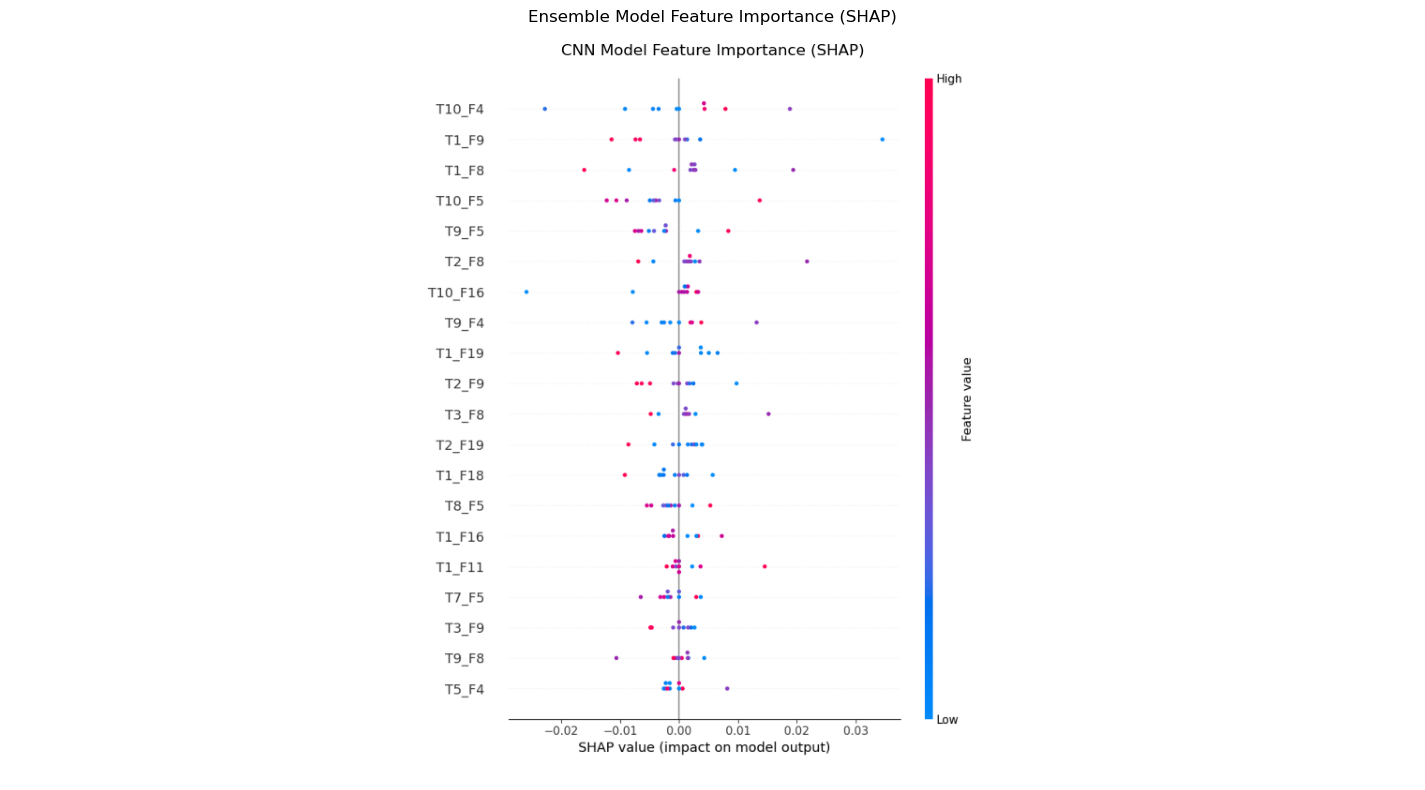

In [ ]:
# Compare SHAP and Permutation explanations
import matplotlib.pyplot as plt
import os
import glob

def safe_load_image(path):
    try:
        return plt.imread(path)
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None

# Look for explanation plots (check all variations of names)
all_plots = glob.glob('results/plots/*.png')
print("Available plots:", all_plots)

plot_paths = {
    'SHAP': [p for p in all_plots if 'shap' in p.lower()],
    'Permutation': [p for p in all_plots if 'permutation' in p.lower()]
}

# Try loading each plot
images = {}
for method, paths in plot_paths.items():
    for path in paths:
        img = safe_load_image(path)
        if img is not None:
            print(f"Found {method} plot at: {path}")
            images[method] = img
            break
    if method not in images:
        print(f"No valid plot found for {method} explanation")

if images:
    # Create comparison visualization
    n_methods = len(images)
    fig, axes = plt.subplots(n_methods, 1, figsize=(15, 8 * n_methods))
    
    if n_methods == 1:
        axes = [axes]  # Make axes iterable when only one method
    
    for ax, (name, img) in zip(axes, images.items()):
        ax.imshow(img)
        ax.set_title(f'Ensemble Model Feature Importance ({name})')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/plots/explanation_method_comparison.png')
    print("Comparison plot saved as 'results/plots/explanation_method_comparison.png'")
else:
    print("No valid explanation plots found to compare")

In [ ]:
# Remove the cache file (if present) and reload the full dataset without using cache
import os
from src.data_preprocessing.data_loader import VANETDataLoader

cache_path = (Path('.') / 'veremi_cached.npz').resolve()
print('Cache path:', cache_path)
if cache_path.exists():
    try:
        os.remove(cache_path)
        print('Deleted cache:', cache_path)
    except Exception as e:
        print('Failed to delete cache:', e)
else:
    print('No cache file found; proceeding to load full CSV')

# Load data without using cache to force reading the full CSV
loader = VANETDataLoader(data_path=str(Path('..').resolve() / 'veremi_dataset.csv'), rows_limit=None, cache_npz=None, use_cache=False)
X, y = loader.load_veremi_data()
print('Loaded X shape:', np.asarray(X).shape)
print('Loaded y shape:', np.asarray(y).shape)

# Double-check file line count
dataset_path = Path('..').resolve() / 'veremi_dataset.csv'
if dataset_path.exists():
    with open(dataset_path, 'r', encoding='utf-8', errors='ignore') as f:
        line_count = sum(1 for _ in f)
    print(f'Number of lines in dataset: {line_count}')
else:
    print('Dataset CSV not found at expected path:', dataset_path)

Cache path: C:\Users\PESU-RF\Documents\Capstone-147\VANET_Misbehavior_XAI\veremi_cached.npz
No cache file found; proceeding to load full CSV
Loaded X shape: (22165610, 20)
Loaded y shape: (22165610,)
Number of lines in dataset: 22165611
